In [31]:
import pandas as pd
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import seaborn as sns
import time
import matplotlib.pyplot as plt
import numpy as np

#-- Lista de empresas
empresa = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Google': 'GOOG',
    'Amazon': 'AMZN',
    'Tesla': 'TSLA',
    'NVIDIA': 'NVDA',
    'Meta': 'META'
}

import warnings
warnings.filterwarnings("ignore")


In [32]:
def split_train_test(empresa,split_point = '2022-07-01'):
    scaler_dict = {}
    train_list = []
    test_list = []
    for name,ativo in empresa.items():
        df = pd.read_csv(f'../Dataset/Main/{name.lower()}_main.csv')
        df['Date'] = pd.to_datetime(df['Date'])

        df_train = df[df.Date < split_point]
        df_test = df[df.Date >= split_point]

        Close_scaler = StandardScaler()
        Coef_scaler = StandardScaler()
        Volume_scaler = StandardScaler()
        Dif_scaler = StandardScaler()

        coef_cols = [x for x in df_train.columns if 'coef' in x]

        df_train[['Close']] = Close_scaler.fit_transform(df_train[['Close']])
        df_train[coef_cols] = Coef_scaler.fit_transform(df_train[coef_cols])
        df_train[['Volume']] = Volume_scaler.fit_transform(df_train[['Volume']])
        df_train[['Dif']] = Dif_scaler.fit_transform(df_train[['Dif']])

        df_test[['Close']] = Close_scaler.transform(df_test[['Close']])
        df_test[coef_cols] = Coef_scaler.transform(df_test[coef_cols])
        df_test[['Volume']] = Volume_scaler.transform(df_test[['Volume']])
        df_test[['Dif']] = Dif_scaler.transform(df_test[['Dif']])

        scaler_dict[name] = {
            'Close':Close_scaler,
            'Coef':Coef_scaler,
            'Volume':Volume_scaler,
            'Dif':Dif_scaler
        }

        df_train.to_csv(f'../Dataset/Train/{name.lower()}_train.csv',index=False)
        train_list.append(df_train)
        
        df_test.to_csv(f'../Dataset/Test/{name.lower()}_test.csv',index=False)
        test_list.append(df_test)

    joblib.dump(Coef_scaler, '../Model/Full_scaler')


    df_train_full = pd.concat(train_list)
    df_train_full.reset_index(drop=True,inplace=True)
    df_train_full.to_csv(f'../Dataset/Train/df_train_full.csv',index=False)

    df_test_full = pd.concat(test_list)
    df_test_full.reset_index(drop=True,inplace=True)
    df_test_full.to_csv(f'../Dataset/Test/df_test_full.csv',index=False)

#split_train_test(empresa,split_point = '2022-07-01')

In [33]:
def config_param(MLmodel, param, cv= 10, n_jobs=-1, scoring = 'balanced_accuracy'):
    
    grid_class = GridSearchCV(MLmodel, param, cv=cv,n_jobs=n_jobs, scoring = scoring)
    
    return MLmodel, grid_class

def get_param(MLmodel, param, X,Y):    
    
    MLmodel, grid_class = config_param(MLmodel, param)
    
    return grid_class.fit(X,Y)


def best_model(MLmodel,data_X,data_y,param):
  print('----------------')
  print('Início do CVGrid')
  inicio = time.time()
  all_param = get_param(MLmodel, param, data_X,data_y)
  best_result = all_param.best_estimator_
  final = time.time() - inicio
  min = final/60 
  print('Final do CVGrid')
  print('Tempo de Execução: {} min '.format(min))
  print('----------------')
  return best_result

def plot_results(y_pred,y_real):

  ### Função de plotagem da matriz de confusão ###

  ''' Esta função realiza o plot da matriz de confusão para análise visual do desempenho '''

  # Criando a matrix de confusão para análise de eficiência
  cnf_matrix = metrics.confusion_matrix(y_pred, y_real)
  
  # Plotagem da matriz de confusão e um Heatmap
  class_names=[0,1] #  Nome das classes
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  
  # Creando o heatmap com a matriz de confusão
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("bottom")
  plt.tight_layout()
  plt.title('Matriz de Confusão', y=1.1)
  plt.ylabel('Valor real')
  plt.xlabel('Valor previsto')



def get_metrics(y_true, y_pred):
    metrics_dict = {
        'ACCUR': metrics.accuracy_score(y_true, y_pred),
        'PREC': metrics.precision_score(y_true, y_pred),
        'RECC': metrics.recall_score(y_true, y_pred),
        'F1': metrics.f1_score(y_true, y_pred),
        'BAL_ACCUR': metrics.balanced_accuracy_score(y_true, y_pred)
    }

    return metrics_dict


In [34]:
rus = RandomUnderSampler(random_state=0)
df_train = pd.read_csv('../Dataset/Train/df_train_full.csv')
df_test = pd.read_csv('../Dataset/tEST/df_test_full.csv')
df_train.sample(10)


,Date,Close,Dif,Volume,Empresa,Symbol,target,moment,Action,coef_3,coef_7,coef_10,coef_15,coef_20,coef_30
12301,2008-11-18,0.027852,0.156442,1.356517,Google,GOOG,0,hold,0,0.311600,0.212134,0.506358,0.707986,0.553456,0.422062
30429,2014-04-15,0.113486,0.076603,3.142538,Meta,META,0,hold,0,-0.074801,-0.089938,0.133441,0.219477,0.603091,0.813268
27330,2011-12-16,0.007619,0.000181,-0.033306,NVIDIA,NVDA,2,buy,1,0.026498,0.109991,0.120028,0.098948,0.067699,0.075613
10416,2019-02-26,0.294343,-0.790907,-1.005144,Microsoft,MSFT,0,hold,0,-0.330508,-1.211181,-1.116537,-0.903474,-0.913606,-0.443579
14450,2017-06-05,0.311260,-0.513188,-0.651750,Google,GOOG,1,sell,1,-0.469297,0.045014,-0.527935,-0.757085,-0.612934,-0.917397
18220,2010-01-13,0.033054,-0.077100,0.905327,Amazon,AMZN,0,hold,0,0.136616,0.137825,0.148402,0.159772,0.059259,0.122104
4636,2018-07-20,0.252667,0.123266,-0.871452,Apple,AAPL,0,hold,0,-0.352317,0.027100,-0.077652,-0.413927,-0.452190,0.083638
30400,2014-03-05,0.147729,-0.647587,1.771608,Meta,META,0,hold,0,-0.325510,0.210053,0.187776,-0.138669,-0.372353,-0.687743
17354,2006-08-04,0.005723,-0.033000,0.810126,Amazon,AMZN,0,hold,0,-0.009287,0.043601,0.144360,0.168614,0.167544,0.182520
14521,2017-09-14,0.291393,0.452968,-0.632901,Google,GOOG,0,hold,0,-0.145591,-0.037392,0.177776,-0.146460,-0.208410,0.012223


In [35]:
df_train.moment.value_counts()

hold     26527
buy       3020
sell      2915
error       35
Name: moment, dtype: int64

In [36]:
df_train.moment.value_counts(normalize=True)

hold     0.816291
buy      0.092932
sell     0.089701
error    0.001077
Name: moment, dtype: float64

In [46]:
X_action_train = df_train[['Close','Volume','coef_3', 'coef_7', 'coef_10', 'coef_15', 'coef_20', 'coef_30']]
y_action_train = df_train[['Action']]
X_resampled_action_train, y_resampled_action_train = rus.fit_resample(X_action_train, y_action_train)

target_list = [1,2]
X_moment_train = df_train[df_train.target.isin(target_list)][['Close','Volume','coef_3', 'coef_7', 'coef_10', 'coef_15', 'coef_20', 'coef_30']]
y_moment_train = df_train[df_train.target.isin(target_list)][['target']].apply(lambda x: x - 1)


X_action_test = df_test[['Close','Volume','coef_3', 'coef_7', 'coef_10', 'coef_15', 'coef_20', 'coef_30']]
y_action_test = df_test[['Action']]

X_moment_test = df_test[df_test.target.isin(target_list)][['Close','Volume','coef_3', 'coef_7', 'coef_10', 'coef_15', 'coef_20', 'coef_30']]
y_moment_test = df_test[df_test.target.isin(target_list)][['target']].apply(lambda x: x - 1)



In [47]:
y_action_test['Action'].value_counts()

0    1619
1     278
Name: Action, dtype: int64

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import NuSVC, SVC
from sklearn.neural_network import MLPClassifier


def get_action_models(models):
    metrics_list_action = []

    for name, model in models.items():
        model.fit(X_resampled_action_train, y_resampled_action_train)
        y_true_train = y_resampled_action_train
        y_pred_train = model.predict(X_resampled_action_train)

        accur_train = metrics.accuracy_score(y_true_train,y_pred_train)
        precision_train = metrics.precision_score(y_true_train,y_pred_train)
        recall_train = metrics.recall_score(y_true_train,y_pred_train)
        f1_train = metrics.f1_score(y_true_train,y_pred_train)
        bal_acc_train = metrics.balanced_accuracy_score(y_true_train,y_pred_train)

        metrics_list_action.append([name, 'Train',accur_train,precision_train,recall_train,f1_train,bal_acc_train])

        y_true_test = y_action_test
        y_pred_test = model.predict(X_action_test)

        accur_test = metrics.accuracy_score(y_true_test,y_pred_test)
        precision_test = metrics.precision_score(y_true_test,y_pred_test)
        recall_test = metrics.recall_score(y_true_test,y_pred_test)
        f1_test = metrics.f1_score(y_true_test,y_pred_test)
        bal_acc_test = metrics.balanced_accuracy_score(y_true_test,y_pred_test)

        metrics_list_action.append([name, 'Test',accur_test,precision_test,recall_test,f1_test,bal_acc_test])
        print(name)

    
    joblib.dump(models, '../Model/Trained_action_models')
    
    return pd.DataFrame(metrics_list_action,columns=['Model', 'Type', 'ACCUR','PREC','RECC','F1','BAL_ACCUR'])    


models = {
    'LogisticRegression': LogisticRegression(random_state=0),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=0),
    'ExtraTreeClassifier': ExtraTreeClassifier(random_state=0),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=0),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=0),
    'RandomForestClassifier': RandomForestClassifier(random_state=0)
}

metrics_actions = get_action_models(models)
metrics_actions.to_csv(f'../Model/metrics_actions.csv',index=False)
metrics_actions


LogisticRegression
DecisionTreeClassifier
ExtraTreeClassifier
AdaBoostClassifier
GradientBoostingClassifier
RandomForestClassifier


,Model,Type,ACCUR,PREC,RECC,F1,BAL_ACCUR
0,LogisticRegression,Train,0.539615,0.553182,0.412060,0.472305,0.539615
1,LogisticRegression,Test,0.480759,0.151037,0.550360,0.237026,0.509584
2,DecisionTreeClassifier,Train,1.000000,1.000000,1.000000,1.000000,1.000000
3,DecisionTreeClassifier,Test,0.538218,0.175000,0.579137,0.268781,0.555164
4,ExtraTreeClassifier,Train,1.000000,1.000000,1.000000,1.000000,1.000000
5,ExtraTreeClassifier,Test,0.508171,0.149733,0.503597,0.230833,0.506277
6,AdaBoostClassifier,Train,0.588693,0.593966,0.560637,0.576820,0.588693
7,AdaBoostClassifier,Test,0.449657,0.158645,0.640288,0.254286,0.528606
8,GradientBoostingClassifier,Train,0.668593,0.663526,0.684087,0.673649,0.668593
9,GradientBoostingClassifier,Test,0.580917,0.203895,0.640288,0.309296,0.605505


In [49]:
metrics_actions[metrics_actions.Type == 'Test'].sort_values('BAL_ACCUR',ascending=False)

,Model,Type,ACCUR,PREC,RECC,F1,BAL_ACCUR
9,GradientBoostingClassifier,Test,0.580917,0.203895,0.640288,0.309296,0.605505
11,RandomForestClassifier,Test,0.590933,0.197816,0.586331,0.295826,0.589027
3,DecisionTreeClassifier,Test,0.538218,0.175000,0.579137,0.268781,0.555164
7,AdaBoostClassifier,Test,0.449657,0.158645,0.640288,0.254286,0.528606
1,LogisticRegression,Test,0.480759,0.151037,0.550360,0.237026,0.509584
5,ExtraTreeClassifier,Test,0.508171,0.149733,0.503597,0.230833,0.506277


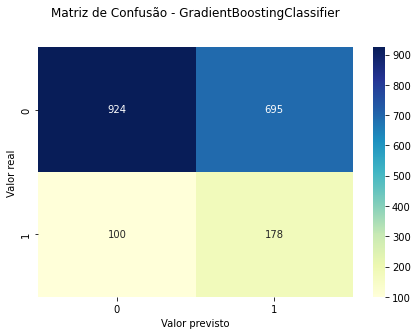

In [50]:
y_pred = models.get('GradientBoostingClassifier').predict(X_action_test)
y_true = y_action_test
### Função de plotagem da matriz de confusão ###

''' Esta função realiza o plot da matriz de confusão para análise visual do desempenho '''

# Criando a matrix de confusão para análise de eficiência
cnf_matrix = metrics.confusion_matrix(y_true, y_pred)

# Plotagem da matriz de confusão e um Heatmap
class_names=[0,1] #  Nome das classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Creando o heatmap com a matriz de confusão
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Matriz de Confusão - GradientBoostingClassifier', y=1.1)
plt.ylabel('Valor real')
plt.xlabel('Valor previsto')
plt.savefig('Matriz de Confusão - GradientBoostingClassifier.png',dpi=1000)


In [51]:
y_moment_train.value_counts()

target
1         3020
0         2915
dtype: int64

In [52]:
y_moment_test.value_counts()

target
0         144
1         133
dtype: int64

In [53]:
def get_moment_models(models):
    metrics_list_action = []

    for name, model in models.items():
        model.fit(X_moment_train, y_moment_train)
        y_true_train = y_moment_train
        y_pred_train = model.predict(X_moment_train)

        accur_train = metrics.accuracy_score(y_true_train,y_pred_train)
        precision_train = metrics.precision_score(y_true_train,y_pred_train)
        recall_train = metrics.recall_score(y_true_train,y_pred_train)
        f1_train = metrics.f1_score(y_true_train,y_pred_train)
        bal_acc_train = metrics.balanced_accuracy_score(y_true_train,y_pred_train)

        metrics_list_action.append([name, 'Train',accur_train,precision_train,recall_train,f1_train,bal_acc_train])

        y_true_test = y_moment_test
        y_pred_test = model.predict(X_moment_test)

        accur_test = metrics.accuracy_score(y_true_test,y_pred_test)
        precision_test = metrics.precision_score(y_true_test,y_pred_test)
        recall_test = metrics.recall_score(y_true_test,y_pred_test)
        f1_test = metrics.f1_score(y_true_test,y_pred_test)
        bal_acc_test = metrics.balanced_accuracy_score(y_true_test,y_pred_test)

        metrics_list_action.append([name, 'Test',accur_test,precision_test,recall_test,f1_test,bal_acc_test])
        print(name)

    joblib.dump(models, '../Model/Trained_moment_models')
    
    return pd.DataFrame(metrics_list_action,columns=['Model', 'Type', 'ACCUR','PREC','RECC','F1','BAL_ACCUR'])    

models = {
    'LogisticRegression': LogisticRegression(random_state=0),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=0),
    'ExtraTreeClassifier': ExtraTreeClassifier(random_state=0),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=0),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=0),
    'RandomForestClassifier': RandomForestClassifier(random_state=0)
}

metrics_moments = get_moment_models(models)
metrics_moments.to_csv(f'../Model/metrics_moments.csv',index=False)
metrics_moments


LogisticRegression
DecisionTreeClassifier
ExtraTreeClassifier
AdaBoostClassifier
GradientBoostingClassifier
RandomForestClassifier


,Model,Type,ACCUR,PREC,RECC,F1,BAL_ACCUR
0,LogisticRegression,Train,0.901601,0.889137,0.921523,0.905041,0.901242
1,LogisticRegression,Test,0.927798,0.931298,0.917293,0.924242,0.927397
2,DecisionTreeClassifier,Train,1.000000,1.000000,1.000000,1.000000,1.000000
3,DecisionTreeClassifier,Test,0.833935,0.812950,0.849624,0.830882,0.834534
4,ExtraTreeClassifier,Train,1.000000,1.000000,1.000000,1.000000,1.000000
5,ExtraTreeClassifier,Test,0.826715,0.851240,0.774436,0.811024,0.824718
6,AdaBoostClassifier,Train,0.908172,0.915687,0.902649,0.909121,0.908271
7,AdaBoostClassifier,Test,0.898917,0.888889,0.902256,0.895522,0.899044
8,GradientBoostingClassifier,Train,0.928728,0.932113,0.927483,0.929793,0.928750
9,GradientBoostingClassifier,Test,0.913357,0.916031,0.902256,0.909091,0.912933


In [54]:
metrics_moments[metrics_moments.Type == 'Test'].sort_values('BAL_ACCUR',ascending=False)

,Model,Type,ACCUR,PREC,RECC,F1,BAL_ACCUR
1,LogisticRegression,Test,0.927798,0.931298,0.917293,0.924242,0.927397
9,GradientBoostingClassifier,Test,0.913357,0.916031,0.902256,0.909091,0.912933
7,AdaBoostClassifier,Test,0.898917,0.888889,0.902256,0.895522,0.899044
11,RandomForestClassifier,Test,0.895307,0.919355,0.857143,0.887160,0.893849
3,DecisionTreeClassifier,Test,0.833935,0.812950,0.849624,0.830882,0.834534
5,ExtraTreeClassifier,Test,0.826715,0.851240,0.774436,0.811024,0.824718


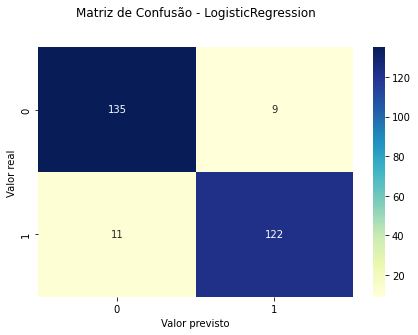

In [60]:
y_pred = models.get('LogisticRegression').predict(X_moment_test)
y_true = y_moment_test
### Função de plotagem da matriz de confusão ###

''' Esta função realiza o plot da matriz de confusão para análise visual do desempenho '''

# Criando a matrix de confusão para análise de eficiência
cnf_matrix = metrics.confusion_matrix(y_true, y_pred)

# Plotagem da matriz de confusão e um Heatmap
class_names=[0,1] #  Nome das classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Creando o heatmap com a matriz de confusão
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Matriz de Confusão - LogisticRegression', y=1.1)
plt.ylabel('Valor real')
plt.xlabel('Valor previsto')
plt.savefig('Matriz de Confusão - GradientBoostingClassifier.png',dpi=1000)
